In [2]:
import pandas as pd
from google.colab import drive

#Load 'all' CSV file
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/MyDrive/wealthnet_features_returns/banknifty.csv'

data = pd.read_csv(file_path)

data.dtypes

Mounted at /content/drive


Datetime                    object
Open                       float64
High                       float64
Low                        float64
Close                      float64
Index Name                  object
1_Min_Returns              float64
5_Min_Returns              float64
10_Min_Returns             float64
1_Min_Returns_Midcap       float64
5_Min_Returns_Midcap       float64
10_Min_Returns_Midcap      float64
1_Min_Returns_Finnifty     float64
5_Min_Returns_Finnifty     float64
10_Min_Returns_Finnifty    float64
1_Min_Returns_Nifty        float64
5_Min_Returns_Nifty        float64
10_Min_Returns_Nifty       float64
dtype: object

Goal: Try and use 10 minute returns of banknifty, finnifty and nifty to evaluate expected returns of midcapnifty, since there is contemporaneous correlation.

In [3]:
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)
# data.drop('Datetime', axis=1, inplace=True)
data.drop('Index Name', axis=1, inplace=True)

data.drop(data.iloc[:, 1:5], inplace=True, axis=1)
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

data.head(10)

,1_Min_Returns,5_Min_Returns,10_Min_Returns,1_Min_Returns_Midcap,5_Min_Returns_Midcap,10_Min_Returns_Midcap,1_Min_Returns_Finnifty,5_Min_Returns_Finnifty,10_Min_Returns_Finnifty,1_Min_Returns_Nifty,5_Min_Returns_Nifty,10_Min_Returns_Nifty
Datetime,,,,,,,,,,,,
2023-01-02 09:26:00+05:30,-14.345187,-3.775988,-23.064453,-7.777778,0.000000,-18.867925,-13.718505,-12.535090,-23.884303,-9.017704,-4.469520,-11.579403
2023-01-02 09:27:00+05:30,1.104167,0.662471,-19.046205,-4.239408,-2.849835,-16.312421,-0.738284,-6.561628,-29.079551,-3.036217,-3.201775,-17.309288
2023-01-02 09:28:00+05:30,-6.496435,-8.226618,-18.989053,-4.310734,-11.047497,-20.061921,-4.192706,-12.251802,-25.208603,-3.009528,-7.148121,-14.919405
2023-01-02 09:29:00+05:30,0.534938,-20.482196,-7.459903,-2.434529,-22.353039,-10.494784,0.712268,-19.219226,-15.775737,-1.021891,-16.077436,-6.210974
2023-01-02 09:30:00+05:30,-2.232665,-21.424932,-15.723690,-3.896194,-22.638889,-18.341230,-3.745733,-21.670498,-20.961048,-4.143223,-20.213998,-12.970634
2023-01-02 09:31:00+05:30,3.873142,-3.219519,-6.994291,11.066720,-3.822417,-3.822417,3.562419,-4.403335,-16.932906,4.891030,-6.320851,-10.787546
2023-01-02 09:32:00+05:30,1.709104,-2.614844,-1.952546,-10.637336,-10.220612,-13.067534,-0.448441,-4.113599,-10.672527,-3.839100,-7.123471,-10.322965
2023-01-02 09:33:00+05:30,22.946898,26.839925,18.591227,12.458241,6.538448,-4.516272,18.729852,18.809141,6.534295,8.952131,4.833266,-2.318309
2023-01-02 09:34:00+05:30,9.498725,35.827289,15.271711,2.085375,11.062409,-11.315358,9.716049,27.829216,8.556505,5.852328,11.711510,-4.384755


Model 1: Using Least Squares Regression, with independent vars (nifty, banknifty 10 min returns) and dependent var (finnifty 10 min return), and comparing expected vs observed values.

In [4]:
correlation_matrix = data.corr()
correlation_matrix

,1_Min_Returns,5_Min_Returns,10_Min_Returns,1_Min_Returns_Midcap,5_Min_Returns_Midcap,10_Min_Returns_Midcap,1_Min_Returns_Finnifty,5_Min_Returns_Finnifty,10_Min_Returns_Finnifty,1_Min_Returns_Nifty,5_Min_Returns_Nifty,10_Min_Returns_Nifty
1_Min_Returns,1.000000,0.438123,0.311811,0.582552,0.261117,0.185450,0.957608,0.416536,0.295865,0.832642,0.364987,0.257663
5_Min_Returns,0.438123,1.000000,0.698349,0.277827,0.616333,0.438208,0.425307,0.960073,0.669204,0.375711,0.842450,0.589855
10_Min_Returns,0.311811,0.698349,1.000000,0.192120,0.435628,0.623585,0.302105,0.672159,0.959949,0.265351,0.590614,0.842766
1_Min_Returns_Midcap,0.582552,0.277827,0.192120,1.000000,0.447583,0.311372,0.568084,0.269909,0.186114,0.685856,0.319065,0.219293
5_Min_Returns_Midcap,0.261117,0.616333,0.435628,0.447583,1.000000,0.702942,0.255734,0.599986,0.423113,0.307151,0.709118,0.497531
10_Min_Returns_Midcap,0.185450,0.438208,0.623585,0.311372,0.702942,1.000000,0.182179,0.427360,0.606641,0.217748,0.502530,0.711617
1_Min_Returns_Finnifty,0.957608,0.425307,0.302105,0.568084,0.255734,0.182179,1.000000,0.439772,0.311892,0.854081,0.378095,0.267159
5_Min_Returns_Finnifty,0.416536,0.960073,0.672159,0.269909,0.599986,0.427360,0.439772,1.000000,0.698977,0.381754,0.862603,0.605598
10_Min_Returns_Finnifty,0.295865,0.669204,0.959949,0.186114,0.423113,0.606641,0.311892,0.698977,1.000000,0.269859,0.604396,0.863456
1_Min_Returns_Nifty,0.832642,0.375711,0.265351,0.685856,0.307151,0.217748,0.854081,0.381754,0.269859,1.000000,0.444256,0.313028


In [5]:
#REDUNDANT MODEL< SCROLL FOR NEXT
import pandas as pd
import statsmodels.api as sm

df = pd.read_csv(file_path)

#Create lagged features for the past 30 minutes for BANKNIFTY and NIFTY; i.e banknifty_lag_1 will be banknifty's  t-1 minute's column for 10 minute returns.
for i in range(1, 31):
    df[f'BANKNIFTY_lag_{i}'] = df['10_Min_Returns'].shift(i)
    df[f'NIFTY_lag_{i}'] = df['10_Min_Returns_Nifty'].shift(i)

df['FINNIFTY'] = df['10_Min_Returns_Finnifty']

# Drop the initial rows where we do not have 30 lags (first 30 rows), and last row where future finnifty doesnt exist
df.dropna(inplace=True)


In [ ]:
df.drop(df.iloc[:, 1:18], inplace=True, axis=1)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

In [ ]:
# #Define variables
# #Include all lagged features of BANKNIFTY and NIFTY
# features = [col for col in df.columns if 'lag' in col]
# X = df[features]
# Y = df['FINNIFTY_future']

# # Add a constant to the model (the intercept)
# X = sm.add_constant(X)

# #Fit the model
# model = sm.OLS(Y, X).fit()

# #Print out the statistics
# print(model.summary())

In [ ]:
# import pandas as pd
# import statsmodels.api as sm

# # Define the list of feature columns
# features = [col for col in df.columns if 'lag' in col]

# # Initialize an empty list to store predictions
# predictions = []
# df['predicted_FINNIFTY'] = 0

# # Iterate through each row in the DataFrame
# for row in df.head(5).itertuples():
#     index = row.Index
#     # Prepare the feature and target data for the current row
#     X = df.loc[[index], features]  # Select the row using .loc to preserve the index
#     X = sm.add_constant(X)  # Add a constant for the intercept

#     Y = df.loc[[index], 'FINNIFTY']  # Select the target variable, preserving the index

#     # Fit the regression model on the current row
#     model = sm.OLS(Y, X).fit()

#     # Make a prediction for the current row
#     prediction = model.predict(X)
#     predictions.append(prediction.iloc[0])
#     df.loc[index, 'predicted_FINNIFTY'] = prediction.iloc[0]


Working Model

In [2]:
import pandas as pd
from google.colab import drive

#Load 'all' CSV file
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/MyDrive/wealthnet_features_returns/banknifty.csv'

df = pd.read_csv(file_path)

df = df.loc[:, ['Datetime','10_Min_Returns','10_Min_Returns_Nifty','10_Min_Returns_Finnifty', '10_Min_Returns_Midcap']]

Mounted at /content/drive


In [3]:
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

df.head(10)

,10_Min_Returns,10_Min_Returns_Nifty,10_Min_Returns_Finnifty,10_Min_Returns_Midcap
Datetime,,,,
2023-01-02 09:26:00+05:30,-23.064453,-11.579403,-23.884303,-18.867925
2023-01-02 09:27:00+05:30,-19.046205,-17.309288,-29.079551,-16.312421
2023-01-02 09:28:00+05:30,-18.989053,-14.919405,-25.208603,-20.061921
2023-01-02 09:29:00+05:30,-7.459903,-6.210974,-15.775737,-10.494784
2023-01-02 09:30:00+05:30,-15.723690,-12.970634,-20.961048,-18.341230
2023-01-02 09:31:00+05:30,-6.994291,-10.787546,-16.932906,-3.822417
2023-01-02 09:32:00+05:30,-1.952546,-10.322965,-10.672527,-13.067534
2023-01-02 09:33:00+05:30,18.591227,-2.318309,6.534295,-4.516272
2023-01-02 09:34:00+05:30,15.271711,-4.384755,8.556505,-11.315358


In [4]:
df.reset_index(inplace=True)

# Set time ranges
time_ranges = {
    'morning_session': ('09:15:00', '10:30:00'),
    'midday_session': ('10:31:00', '14:00:00'),
    'afternoon_session': ('14:01:00', '20:00:00')
}

# Filtering the data
morning_df = df[(df['Datetime'].dt.time >= pd.to_datetime(time_ranges['morning_session'][0]).time()) &
                        (df['Datetime'].dt.time <= pd.to_datetime(time_ranges['morning_session'][1]).time())]

midday_df = df[(df['Datetime'].dt.time >= pd.to_datetime(time_ranges['midday_session'][0]).time()) &
                       (df['Datetime'].dt.time <= pd.to_datetime(time_ranges['midday_session'][1]).time())]

afternoon_df = df[(df['Datetime'].dt.time >= pd.to_datetime(time_ranges['afternoon_session'][0]).time()) &
                          (df['Datetime'].dt.time <= pd.to_datetime(time_ranges['afternoon_session'][1]).time())]

# Now we have three dataframes: morning_df, midday_df, and afternoon_df
morning_df
# midday_df
# afternoon_df

,Datetime,10_Min_Returns,10_Min_Returns_Nifty,10_Min_Returns_Finnifty,10_Min_Returns_Midcap
0,2023-01-02 09:26:00+05:30,-23.064453,-11.579403,-23.884303,-18.867925
1,2023-01-02 09:27:00+05:30,-19.046205,-17.309288,-29.079551,-16.312421
2,2023-01-02 09:28:00+05:30,-18.989053,-14.919405,-25.208603,-20.061921
3,2023-01-02 09:29:00+05:30,-7.459903,-6.210974,-15.775737,-10.494784
4,2023-01-02 09:30:00+05:30,-15.723690,-12.970634,-20.961048,-18.341230
...,...,...,...,...,...
145061,2024-04-30 10:26:00+05:30,-0.030277,-4.287797,1.964322,-12.752238
145062,2024-04-30 10:27:00+05:30,9.752424,0.329867,8.978568,-13.473336
145063,2024-04-30 10:28:00+05:30,16.369984,0.725688,13.596053,-14.329865
145064,2024-04-30 10:29:00+05:30,8.400366,-1.737226,7.059517,-12.309904


In [ ]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm

# # Assuming 'df' is your dataframe with the appropriate columns
# # Adding a new column to store predictions
# df['Predicted_10_Min_Returns_Midcap'] = np.nan

# # Number of rows for rolling
# rolling_window = 30

# # Iterate over the dataframe, leaving out the last row in each iteration for prediction
# for start in range(len(df) - rolling_window):
#     end = start + rolling_window
#     # Training data
#     X_train = df.iloc[start:end][['10_Min_Returns', '10_Min_Returns_Nifty', '10_Min_Returns_Finnifty']]
#     y_train = df.iloc[start:end]['10_Min_Returns_Midcap']
#     # Adding a constant to the model for the intercept
#     X_train = sm.add_constant(X_train)
#     # Fit model
#     model = sm.OLS(y_train, X_train).fit()

#     # Data for prediction (next row after the window)
#     X_pred = df.iloc[[end]][['10_Min_Returns', '10_Min_Returns_Nifty', '10_Min_Returns_Finnifty']]
#     X_pred = sm.add_constant(X_pred, has_constant='add')
#     # Predict and store the result in the dataframe
#     df.loc[df.index[end], 'Predicted_10_Min_Returns_Midcap'] = model.predict(X_pred).values[0]


In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Adding a new column to store predictions
df['Predicted_10_Min_Returns_Midcap'] = np.nan

#split data into train test sets
splitlimit_morning = int(len(morning_df)*0.8)
splitlimit_midday = int(len(midday_df)*0.8)
splitlimit_afternoon = int(len(afternoon_df)*0.8)

X_train_morning, X_test_morning = morning_df[:splitlimit_morning][['10_Min_Returns', '10_Min_Returns_Nifty', '10_Min_Returns_Finnifty']], morning_df[splitlimit_morning:][['10_Min_Returns', '10_Min_Returns_Nifty', '10_Min_Returns_Finnifty']]
y_train_morning, y_test_morning = morning_df[:splitlimit_morning]['10_Min_Returns_Midcap'], morning_df[splitlimit_morning:]['10_Min_Returns_Midcap']

X_train_midday, X_test_midday = midday_df[:splitlimit_midday][['10_Min_Returns', '10_Min_Returns_Nifty', '10_Min_Returns_Finnifty']], midday_df[splitlimit_midday:][['10_Min_Returns', '10_Min_Returns_Nifty', '10_Min_Returns_Finnifty']]
y_train_midday, y_test_midday = midday_df[:splitlimit_midday]['10_Min_Returns_Midcap'], midday_df[splitlimit_midday:]['10_Min_Returns_Midcap']

X_train_afternoon, X_test_afternoon = afternoon_df[:splitlimit_afternoon][['10_Min_Returns', '10_Min_Returns_Nifty', '10_Min_Returns_Finnifty']], afternoon_df[splitlimit_afternoon:][['10_Min_Returns', '10_Min_Returns_Nifty', '10_Min_Returns_Finnifty']]
y_train_afternoon, y_test_afternoon = afternoon_df[:splitlimit_afternoon]['10_Min_Returns_Midcap'], afternoon_df[splitlimit_afternoon:]['10_Min_Returns_Midcap']

X_train_morning = sm.add_constant(X_train_morning)
X_train_midday = sm.add_constant(X_train_midday)
X_train_afternoon = sm.add_constant(X_train_afternoon)

model_morning = sm.OLS(y_train_morning, X_train_morning).fit()
model_midday = sm.OLS(y_train_midday, X_train_midday).fit()
model_afternoon = sm.OLS(y_train_afternoon, X_train_afternoon).fit()


In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Adding columns to store predictions
morning_df['Predicted_10_Min_Returns_Midcap'] = np.nan
midday_df['Predicted_10_Min_Returns_Midcap'] = np.nan
afternoon_df['Predicted_10_Min_Returns_Midcap'] = np.nan

# Make predictions for the test sets
X_test_morning = sm.add_constant(X_test_morning)
X_test_midday = sm.add_constant(X_test_midday)
X_test_afternoon = sm.add_constant(X_test_afternoon)

# Use .iloc to slice based on position
morning_pred = morning_df.iloc[splitlimit_morning:, morning_df.columns.get_loc('Predicted_10_Min_Returns_Midcap')]
midday_pred = midday_df.iloc[splitlimit_midday:, midday_df.columns.get_loc('Predicted_10_Min_Returns_Midcap')]
afternoon_pred = afternoon_df.iloc[splitlimit_afternoon:, afternoon_df.columns.get_loc('Predicted_10_Min_Returns_Midcap')]

morning_pred = model_morning.predict(X_test_morning)
midday_pred = model_midday.predict(X_test_midday)
afternoon_pred = model_afternoon.predict(X_test_afternoon)

# Put the predicted values back into the dataframes at the correct index
morning_df.iloc[splitlimit_morning:, morning_df.columns.get_loc('Predicted_10_Min_Returns_Midcap')] = morning_pred
midday_df.iloc[splitlimit_midday:, midday_df.columns.get_loc('Predicted_10_Min_Returns_Midcap')] = midday_pred
afternoon_df.iloc[splitlimit_afternoon:, afternoon_df.columns.get_loc('Predicted_10_Min_Returns_Midcap')] = afternoon_pred

# Compare predicted values with actual values
mse_morning = mean_squared_error(y_test_morning, morning_pred)
mae_morning = mean_absolute_error(y_test_morning, morning_pred)


mse_midday = mean_squared_error(y_test_midday, midday_pred)
mae_midday = mean_absolute_error(y_test_midday, midday_pred)

mse_afternoon = mean_squared_error(y_test_afternoon, afternoon_pred)
mae_afternoon = mean_absolute_error(y_test_afternoon, afternoon_pred)

print(f"Morning MSE: {mse_morning}, MAE: {mae_morning}")
print(f"Midday MSE: {mse_midday}, MAE: {mae_midday}")
print(f"Afternoon MSE: {mse_afternoon}, MAE: {mae_afternoon}")

# Optionally, compare the train values as well

# morning_df['Predicted_10_Min_Returns_Midcap'] = np.nan
# midday_df['Predicted_10_Min_Returns_Midcap'] = np.nan
# afternoon_df['Predicted_10_Min_Returns_Midcap'] = np.nan

# # Make predictions for the test sets
# X_test_morning = sm.add_constant(X_test_morning)
# X_test_midday = sm.add_constant(X_test_midday)
# X_test_afternoon = sm.add_constant(X_test_afternoon)

# morning_pred = model_morning.predict(X_test_morning)
# midday_pred = model_midday.predict(X_test_midday)
# afternoon_pred = model_afternoon.predict(X_test_afternoon)

# # Use .loc to align the predictions with the correct index labels
# morning_df.loc[X_test_morning.index, 'Predicted_10_Min_Returns_Midcap'] = morning_pred
# midday_df.loc[X_test_midday.index, 'Predicted_10_Min_Returns_Midcap'] = midday_pred
# afternoon_df.loc[X_test_afternoon.index, 'Predicted_10_Min_Returns_Midcap'] = afternoon_pred

# # Compare predicted values with actual values
# mse_morning = mean_squared_error(y_test_morning, morning_pred)
# mae_morning = mean_absolute_error(y_test_morning, morning_pred)

# mse_midday = mean_squared_error(y_test_midday, midday_pred)
# mae_midday = mean_absolute_error(y_test_midday, midday_pred)

# mse_afternoon = mean_squared_error(y_test_afternoon, afternoon_pred)
# mae_afternoon = mean_absolute_error(y_test_afternoon, afternoon_pred)

# print(f"Morning MSE: {mse_morning}, MAE: {mae_morning}")
# print(f"Midday MSE: {mse_midday}, MAE: {mae_midday}")
# print(f"Afternoon MSE: {mse_afternoon}, MAE: {mae_afternoon}")



# train_predictions_morning = model_morning.predict(sm.add_constant(X_train_morning))
# train_predictions_midday = model_midday.predict(sm.add_constant(X_train_midday))
# train_predictions_afternoon = model_afternoon.predict(sm.add_constant(X_train_afternoon))

# train_mse_morning = mean_squared_error(y_train_morning, train_predictions_morning)
# train_mae_morning = mean_absolute_error(y_train_morning, train_predictions_morning)

# train_mse_midday = mean_squared_error(y_train_midday, train_predictions_midday)
# train_mae_midday = mean_absolute_error(y_train_midday, train_predictions_midday)

# train_mse_afternoon = mean_squared_error(y_train_afternoon, train_predictions_afternoon)
# train_mae_afternoon = mean_absolute_error(y_train_afternoon, train_predictions_afternoon)

# print(f"Train Morning MSE: {train_mse_morning}, MAE: {train_mae_morning}")
# print(f"Train Midday MSE: {train_mse_midday}, MAE: {train_mae_midday}")
# print(f"Train Afternoon MSE: {train_mse_afternoon}, MAE: {train_mae_afternoon}")


Morning MSE: 215.2395113087449, MAE: 9.919828994128268
Midday MSE: 58.538733239885005, MAE: 4.934874556327077
Afternoon MSE: 61.11083034639301, MAE: 5.510355121622585


<ipython-input-6-585c15406ce3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morning_df['Predicted_10_Min_Returns_Midcap'] = np.nan
<ipython-input-6-585c15406ce3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  midday_df['Predicted_10_Min_Returns_Midcap'] = np.nan
<ipython-input-6-585c15406ce3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [10]:
r_squared_morning = model_morning.rsquared
r_squared_midday = model_midday.rsquared
r_squared_afternoon = model_afternoon.rsquared

print(f"Morning R-squared: {r_squared_morning}")
print(f"Midday R-squared: {r_squared_midday}")
print(f"Afternoon R-squared: {r_squared_afternoon}")

Morning R-squared: 0.5481910155624327
Midday R-squared: 0.48301796488409965
Afternoon R-squared: 0.5425866986610146


In [10]:
morning_df.dropna(inplace=True)
midday_df.dropna(inplace=True)
afternoon_df.dropna(inplace=True)

<ipython-input-10-0ff4eb83434c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morning_df.dropna(inplace=True)
<ipython-input-10-0ff4eb83434c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  midday_df.dropna(inplace=True)
<ipython-input-10-0ff4eb83434c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afternoon_df.dropna(inplace=True)


In [11]:
#merge morning, midday and afternoon dfs by datetime
df = pd.concat([morning_df, midday_df, afternoon_df])
df = df.sort_values(by='Datetime')
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.set_index('Datetime', inplace=True)


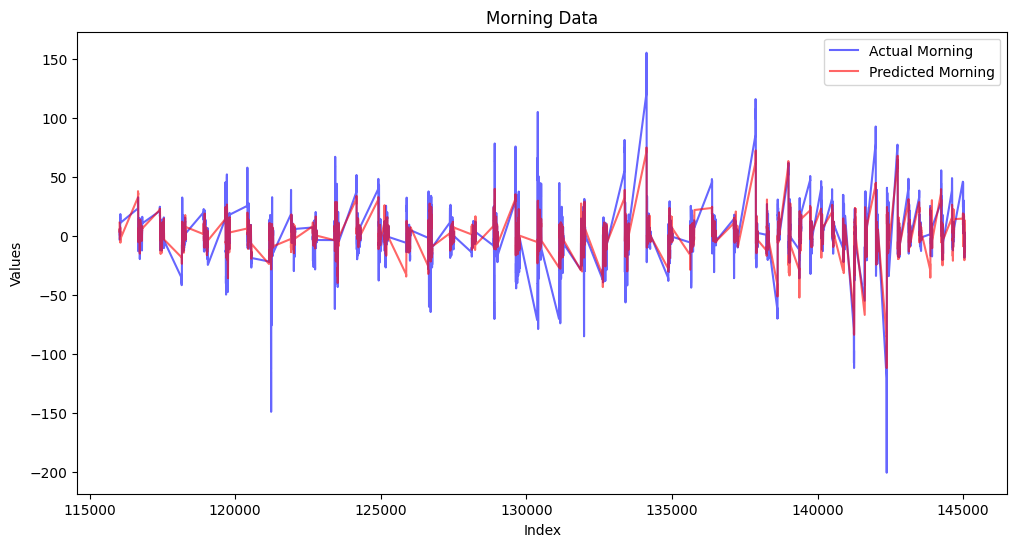

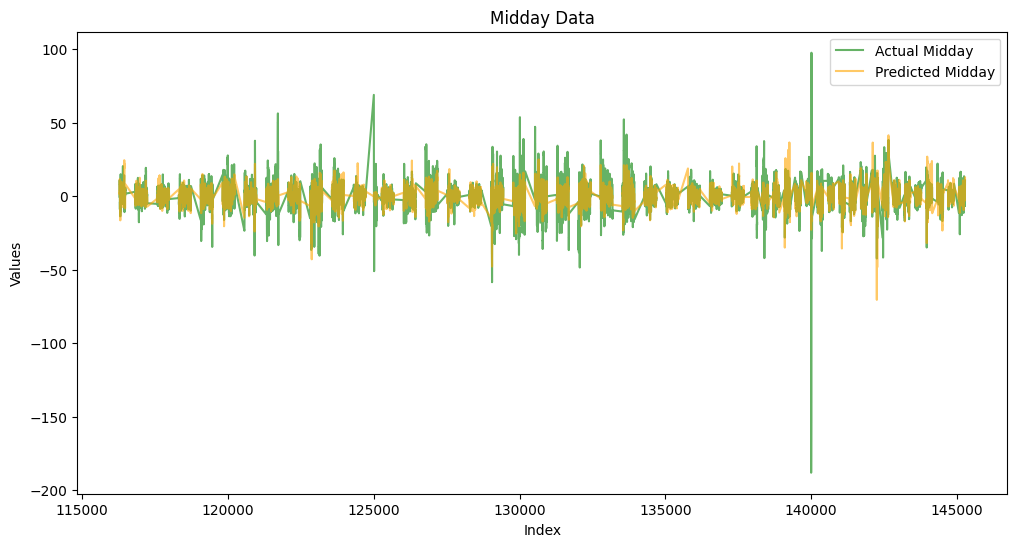

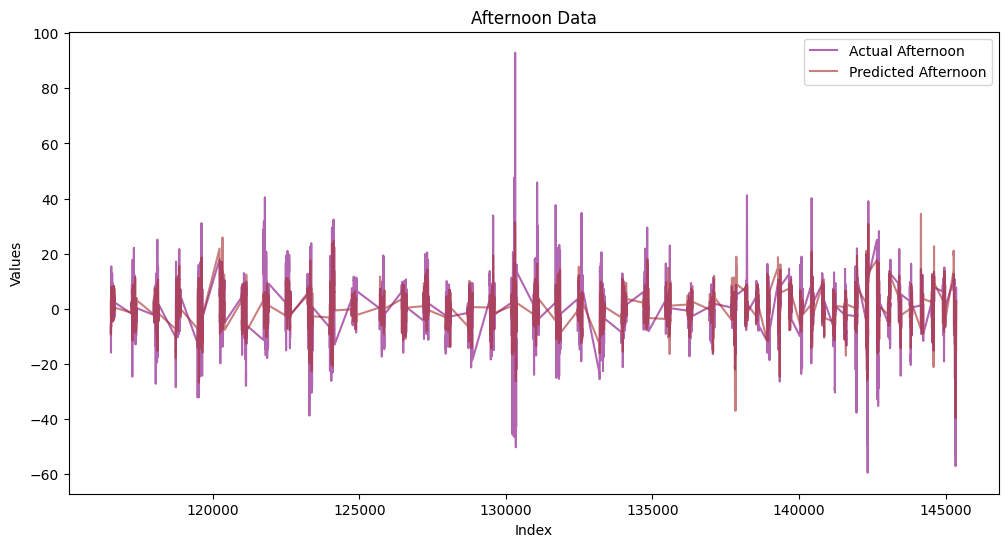

In [12]:
import matplotlib.pyplot as plt

# Plot morning data
plt.figure(figsize=(12, 6))
plt.plot(y_test_morning, label='Actual Morning', alpha=0.6, color='blue')
plt.plot(morning_pred, label='Predicted Morning', alpha=0.6, color='red')
plt.legend()
plt.title('Morning Data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()

# Plot midday data
plt.figure(figsize=(12, 6))
plt.plot(y_test_midday, label='Actual Midday', alpha=0.6, color='green')
plt.plot(midday_pred, label='Predicted Midday', alpha=0.6, color='orange')
plt.legend()
plt.title('Midday Data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()

# Plot afternoon data
plt.figure(figsize=(12, 6))
plt.plot(y_test_afternoon, label='Actual Afternoon', alpha=0.6, color='purple')
plt.plot(afternoon_pred, label='Predicted Afternoon', alpha=0.6, color='brown')
plt.legend()
plt.title('Afternoon Data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()



In [13]:
morning_df.dropna(inplace=True)
midday_df.dropna(inplace=True)
afternoon_df.dropna(inplace=True)

-1.136623717360627
0.16438609767194406
-0.3642921409133947


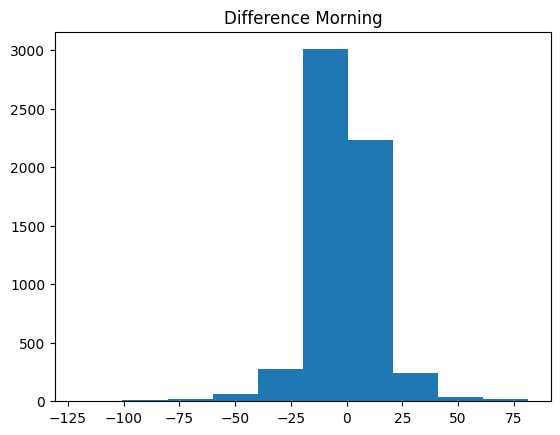

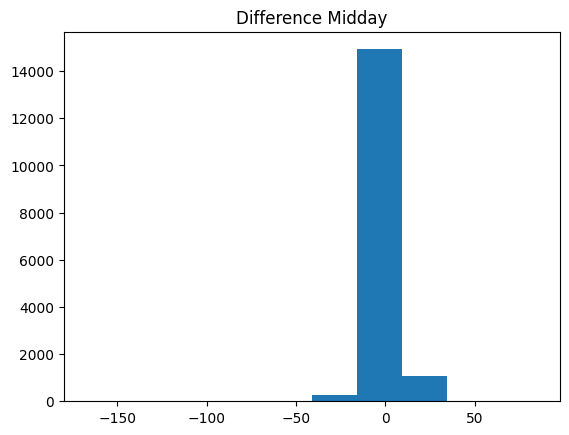

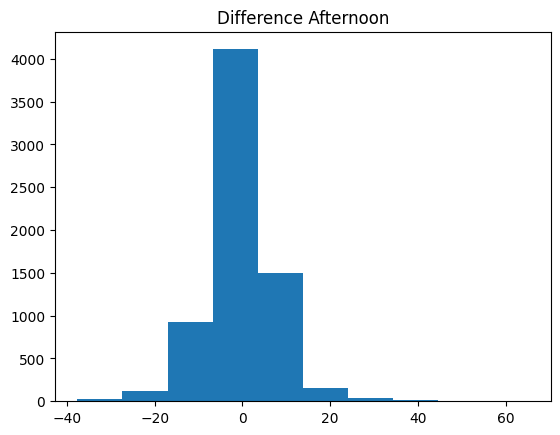

In [14]:
import matplotlib.pyplot as plt

difference_morning = y_test_morning - morning_pred
difference_midday = y_test_midday - midday_pred
difference_afternoon = y_test_afternoon - afternoon_pred

print(difference_morning.mean())
print(difference_midday.mean())
print(difference_afternoon.mean())

#Mean is showing to be centered around -1.136623717360627, 0.16438609767194406, -0.3642921409133947 for the 3 session dataframes. Is this enough to trade with?

plt.hist(difference_morning)
plt.title('Difference Morning')
plt.show()

plt.hist(difference_midday)
plt.title('Difference Midday')
plt.show()

plt.hist(difference_afternoon)
plt.title('Difference Afternoon')
plt.show()


#Next step: save the 3 dataframes into a common dataframe, drop any repeated timestamp or nan values. Use this, if useful, in backtesting.

In [17]:
import pandas as pd

difference_morning = difference_morning.to_frame()
difference_midday = difference_midday.to_frame()
difference_afternoon = difference_afternoon.to_frame()

<Axes: >

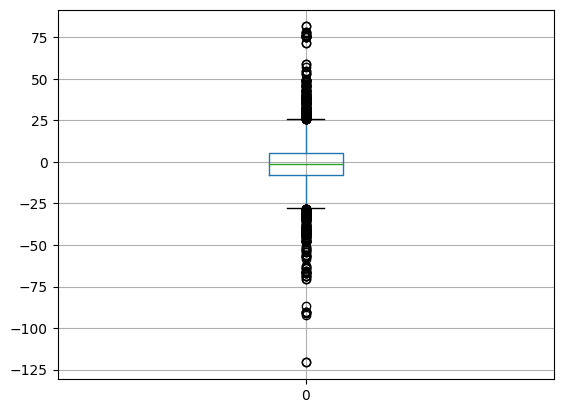

In [18]:
difference_morning.boxplot()

In [61]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# # Calculate errors in terms of basis points
# mae = mean_absolute_error(df['10_Min_Returns_Finnifty'].dropna(), df['Predicted_10_Min_Returns_Finnifty'].dropna())
# mse = mean_squared_error(df['10_Min_Returns_Finnifty'].dropna(), df['Predicted_10_Min_Returns_Finnifty'].dropna())
# rmse = mse ** 0.5

# print("Mean Absolute Error (MAE):", mae)
# print("Mean Squared Error (MSE):", mse)
# print("Root Mean Squared Error (RMSE):", rmse)

# # Plotting
# # plt.figure(figsize=(14, 7))

# # Line plot for actual vs. predicted values
# # plt.subplot(1, 2, 1)

# #Group by date
# grouped = df.groupby(df.index.date)

# # Create subplots
# fig, axs = plt.subplots(nrows=len(grouped), figsize=(10, 3 * len(grouped)))  # Adjust the size as necessary

# for (date, group), ax in zip(grouped, axs):
#     ax.plot(group.index, group['10_Min_Returns_Finnifty'], label='Actual Returns', alpha=0.6)
#     ax.plot(group.index, group['Predicted_10_Min_Returns_Finnifty'], label='Predicted Returns', alpha=0.6)
#     ax.set_title(f'Data for {date}')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Returns')
#     ax.legend()

# plt.tight_layout()
# plt.show()

# # # Scatter plot for actual vs. predicted values
# # plt.subplot(1, 2, 2)
# # plt.scatter(df['10_Min_Returns_Finnifty'], df['Predicted_10_Min_Returns_Finnifty'], alpha=0.5)
# # plt.title('Prediction vs Actual Returns')
# # plt.xlabel('Actual Returns')
# # plt.ylabel('Predicted Returns')
# # plt.plot([-100, 100], [-100, 100], 'r--')  # Adding a reference line

# plt.show()

In [63]:
path = '/content/drive/My Drive/backtest_data_convergence.csv'
df.to_csv(path, index=True)